In [4]:
import joblib
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [5]:
df = pd.read_csv('ipl.csv')
df.head(5)

,mid,date,venue,bat_team,bowl_team,batsman,bowler,runs,wickets,overs,runs_last_5,wickets_last_5,striker,non-striker,total
0,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,SC Ganguly,P Kumar,1,0,0.1,1,0,0,0,222
1,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,1,0,0.2,1,0,0,0,222
2,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,2,0,0.2,2,0,0,0,222
3,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,2,0,0.3,2,0,0,0,222
4,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,2,0,0.4,2,0,0,0,222


In [6]:
cols_to_drop = ['mid', 'batsman', 'bowler', 'striker', 'non-striker']
df.drop(cols_to_drop, axis=1, inplace=True)
df.head(2)

,date,venue,bat_team,bowl_team,runs,wickets,overs,runs_last_5,wickets_last_5,total
0,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,1,0,0.1,1,0,222
1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,1,0,0.2,1,0,222


In [7]:
# Converting the date column to datetime format
df['date'] = df['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [8]:
# Removing temporary teams or teams not available now
consistent_teams = [
    'Chennai Super Kings', 'Delhi Daredevils', 'Kings XI Punjab',
    'Kolkata Knight Riders', 'Mumbai Indians', 'Rajasthan Royals',
    'Royal Challengers Bangalore', 'Sunrisers Hyderabad'
]

In [9]:
df = df[
    (df['bat_team'].isin(consistent_teams)) &
    (df['bowl_team'].isin(consistent_teams))
]

In [10]:
# Filtering out the first five overs data
df = df[df['overs'] > 5.0]

In [13]:
# Updating the mapping function to handle additional stadiums
def f(x):
    if x == 'M Chinnaswamy Stadium':
        return 'M Chinnaswamy Stadium, Bangalore'
    elif x == 'Feroz Shah Kotla':
        return 'Feroz Shah Kotla, Delhi'
    elif x == 'Wankhede Stadium':
        return 'Wankhede Stadium, Mumbai'
    elif x == 'Sawai Mansingh Stadium':
        return 'Sawai Mansingh Stadium, Jaipur'
    elif x == 'Eden Gardens':
        return 'Eden Gardens, Kolkata'
    elif x == 'Dr DY Patil Sports Academy':
        return 'Dr DY Patil Sports Academy, Mumbai'
    elif x == 'Himachal Pradesh Cricket Association Stadium':
        return 'Himachal Pradesh Cricket Association Stadium, Dharamshala'
    elif x == 'Subrata Roy Sahara Stadium':
        return 'Maharashtra Cricket Association Stadium, Pune'
    elif x == 'Shaheed Veer Narayan Singh International Stadium':
        return 'Raipur International Cricket Stadium, Raipur'
    elif x == 'JSCA International Stadium Complex':
        return 'JSCA International Stadium Complex, Ranchi'
    elif x == 'Maharashtra Cricket Association Stadium':
        return 'Maharashtra Cricket Association Stadium, Pune'
    elif x == 'Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium':
        return 'ACA-VDCA Stadium, Visakhapatnam'
    elif x == 'Punjab Cricket Association IS Bindra Stadium, Mohali':
        return 'Punjab Cricket Association Stadium, Mohali'
    elif x == 'Holkar Cricket Stadium':
        return 'Holkar Cricket Stadium, Indore'
    elif x == 'Sheikh Zayed Stadium':
        return 'Sheikh Zayed Stadium, Abu-Dhabi'
    elif x == 'Sharjah Cricket Stadium':
        return 'Sharjah Cricket Stadium, Sharjah'
    elif x == 'Dubai International Cricket Stadium':
        return 'Dubai International Cricket Stadium, Dubai'
    elif x == 'Barabati Stadium':
        return 'Barabati Stadium, Cuttack'
    else:
        return x

In [14]:
# List of stadiums to ignore
ignored_stadiums = [
    'Newlands', 'St George\'s Park', 'Kingsmead', 'SuperSport Park',
    'Buffalo Park', 'New Wanderers Stadium', 'De Beers Diamond Oval',
    'OUTsurance Oval', 'Brabourne Stadium'
]

In [15]:
# Removing rows where 'venue' column matches the ignored stadiums
df = df[True^(df['venue'].isin(ignored_stadiums))]

# Applying the mapping function to update stadium names
df['venue'] = df['venue'].apply(f)

In [16]:
df_new = pd.get_dummies(data=df, columns=['venue', 'bat_team', 'bowl_team'])

In [17]:
df_new = df_new[['date', 'venue_ACA-VDCA Stadium, Visakhapatnam',
    'venue_Barabati Stadium, Cuttack', 'venue_Dr DY Patil Sports Academy, Mumbai',
    'venue_Dubai International Cricket Stadium, Dubai',
    'venue_Eden Gardens, Kolkata', 'venue_Feroz Shah Kotla, Delhi',
    'venue_Himachal Pradesh Cricket Association Stadium, Dharamshala',
    'venue_Holkar Cricket Stadium, Indore',
    'venue_JSCA International Stadium Complex, Ranchi',
    'venue_M Chinnaswamy Stadium, Bangalore',
    'venue_MA Chidambaram Stadium, Chepauk',
    'venue_Maharashtra Cricket Association Stadium, Pune',
    'venue_Punjab Cricket Association Stadium, Mohali',
    'venue_Raipur International Cricket Stadium, Raipur',
    'venue_Rajiv Gandhi International Stadium, Uppal',
    'venue_Sardar Patel Stadium, Motera',
    'venue_Sawai Mansingh Stadium, Jaipur',
    'venue_Sharjah Cricket Stadium, Sharjah',
    'venue_Sheikh Zayed Stadium, Abu-Dhabi',
    'venue_Wankhede Stadium, Mumbai', 'bat_team_Chennai Super Kings',
    'bat_team_Delhi Daredevils', 'bat_team_Kings XI Punjab',
    'bat_team_Kolkata Knight Riders', 'bat_team_Mumbai Indians',
    'bat_team_Rajasthan Royals', 'bat_team_Royal Challengers Bangalore',
    'bat_team_Sunrisers Hyderabad', 'bowl_team_Chennai Super Kings',
    'bowl_team_Delhi Daredevils', 'bowl_team_Kings XI Punjab',
    'bowl_team_Kolkata Knight Riders', 'bowl_team_Mumbai Indians',
    'bowl_team_Rajasthan Royals', 'bowl_team_Royal Challengers Bangalore',
    'bowl_team_Sunrisers Hyderabad', 'runs', 'wickets', 'overs',
    'runs_last_5', 'wickets_last_5', 'total']]

In [18]:
df_new.reset_index(inplace=True)

In [19]:
df_new.drop('index', inplace=True, axis=1)

df_new.head(2)

,date,"venue_ACA-VDCA Stadium, Visakhapatnam","venue_Barabati Stadium, Cuttack","venue_Dr DY Patil Sports Academy, Mumbai","venue_Dubai International Cricket Stadium, Dubai","venue_Eden Gardens, Kolkata","venue_Feroz Shah Kotla, Delhi","venue_Himachal Pradesh Cricket Association Stadium, Dharamshala","venue_Holkar Cricket Stadium, Indore","venue_JSCA International Stadium Complex, Ranchi",...,bowl_team_Mumbai Indians,bowl_team_Rajasthan Royals,bowl_team_Royal Challengers Bangalore,bowl_team_Sunrisers Hyderabad,runs,wickets,overs,runs_last_5,wickets_last_5,total
0,2008-04-18,False,False,False,False,False,False,False,False,False,...,False,False,True,False,61,0,5.1,59,0,222
1,2008-04-18,False,False,False,False,False,False,False,False,False,...,False,False,True,False,61,1,5.2,59,1,222


In [20]:

# *Feature Scaling*
scaler = StandardScaler()
scaled_cols = scaler.fit_transform(df_new[['runs', 'wickets', 'overs', 'runs_last_5', 'wickets_last_5']])

# Save the scaler
pickle.dump(scaler, open('scaler.pkl', 'wb'))

In [21]:
scaled_cols = pd.DataFrame(scaled_cols, columns=['runs', 'wickets', 'overs', 'runs_last_5', 'wickets_last_5'])
df_new.drop(['runs', 'wickets', 'overs', 'runs_last_5', 'wickets_last_5'], axis=1, inplace=True)
df_new = pd.concat([df_new, scaled_cols], axis=1)

In [22]:
X_train = df_new.drop('total', axis=1) [df_new['date'].dt.year<=2016]
X_test = df_new.drop('total',axis=1)[df_new['date'].dt.year>=2017]


In [23]:
X_train.drop('date', inplace=True, axis=1)
X_test.drop('date', inplace=True, axis=1)

In [24]:
y_train = df_new[df_new['date'].dt.year<=2016]['total'].values
y_test = df_new[df_new['date'].dt.year>=2017]['total'].values

In [25]:
ridge = Ridge()
# Hyperparameter tuning
parameters = {'alpha': [1e-3, 1e-2, 1, 5, 10, 20]}

ridge_regressor = RandomizedSearchCV(ridge, parameters, cv=10, scoring='neg_mean_squared_error')
ridge_regressor.fit(X_train, y_train)

c:\Users\Chala\OneDrive\Desktop\cricket_analytics_project\env\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=10, estimator=Ridge(),
                   param_distributions={'alpha': [0.001, 0.01, 1, 5, 10, 20]},
                   scoring='neg_mean_squared_error')

In [26]:
# Print best parameters and best score
print("Best parameters:", ridge_regressor.best_params_)
print("Best score:", ridge_regressor.best_score_)


prediction_r = ridge_regressor.predict(X_test)
print('MAE:', mean_absolute_error(y_test, prediction_r))
print('MSE:', mean_squared_error(y_test, prediction_r))
print('RMSE:', np.sqrt(mean_squared_error(y_test, prediction_r)))
print(f'R² Score of Ridge: {r2_score(y_test, prediction_r)}')

Best parameters: {'alpha': 20}
Best score: -348.05802899276
MAE: 12.36889071810395
MSE: 266.53138520332845
RMSE: 16.325788961129213
R² Score of Ridge: 0.7369422052295995


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\Chala\AppData\Local\Temp\ipykernel_25684\2939335344.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test - prediction_r, kde=True)


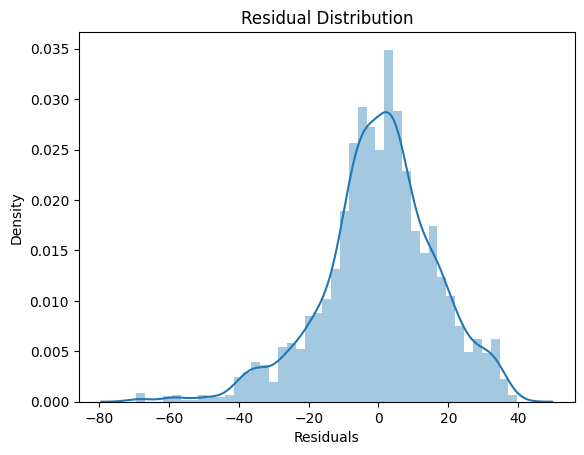

In [28]:
# *Residual Plot*
sns.distplot(y_test - prediction_r, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Residuals")
plt.show()

In [ ]:
import joblib

# Save only the best estimator (best Ridge model)
joblib.dump(ridge_regressor.best_estimator_, 'iplmodel_ridge.sav')

print("Best Model saved as iplmodel_ridge.sav")

Best Model saved as iplmodel_ridge.sav
